In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from n_framework import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
@inplace
def transformi(b): b[x]= [TF.to_tensor(o) for o in b[x]]

In [5]:
bs=256
tds = dsd.with_transform(transformi)

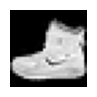

In [6]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

In [7]:
cf = collate_dict(ds)

In [8]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd,bs, **kwargs): return {k: DataLoader(v,bs, **kwargs) for k,v in dsd.items()}

In [9]:
dls = data_loaders(tds,bs, collate_fn=collate_)

In [10]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [11]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

In [12]:
labels = ds.features[y].names

In [13]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [14]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

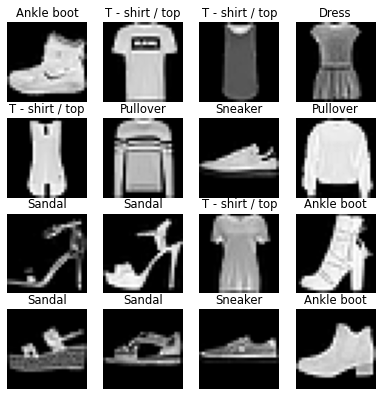

In [15]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

Warmup Classify

In [16]:
bs=256
lr=0.4

In [17]:
cnn = nn.Sequential(
    conv(1,4),   #14,14
    conv(4,8),   #7,7
    conv(8,16),  #4,4
    conv(16,16), #2,2
    conv(16,10, act=False), #1,1
    nn.Flatten()).to(def_device)

In [18]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5,cnn, F.cross_entropy,opt,dt,dv)

0 0.7291657647132873 0.7363
1 0.6062285463571548 0.7833
2 0.4742818268060684 0.8322
3 0.4347657320022583 0.8449
4 0.404042498254776 0.8556


In [19]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

## Autoencoder

In [20]:
def deconv(ni,nf,ks=3,act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni,nf,stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [21]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [22]:
def eval(model,loss_func, valid_dl,epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count +=n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f"{tot_loss/count:.3f}")

In [23]:
def fit(epochs, model,loss_func,opt,train_dl,valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb),xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model,loss_func,valid_dl,epoch)

In [56]:
ae = nn.Sequential(#28x28
    nn.ZeroPad2d(2), #32x32
    conv(1,2), #16x16
    conv(2,4),# 8x8
    #conv(4,8),#4x4
    #deconv(8,4), #8x8
    deconv(4,2),#16x16
    deconv(2,1,act=False),#32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [57]:
eval(ae, F.mse_loss,dv)

0 0.144


In [58]:
opt = optim.SGD(ae.parameters(),lr=0.01)
fit(5,ae, F.mse_loss,opt,dt,dv)

0 0.134
1 0.129
2 0.126
3 0.124
4 0.121


In [48]:
opt = optim.SGD(ae.parameters(),lr=0.1)
fit(5,ae, F.mse_loss,opt,dt,dv)

0 0.015
1 0.015
2 0.015
3 0.015
4 0.015


In [44]:
opt = optim.AdamW(ae.parameters(),lr=0.01)
fit(5,ae,F.l1_loss,opt,dt,dv)

0 0.079
1 0.077
2 0.075
3 0.074
4 0.073


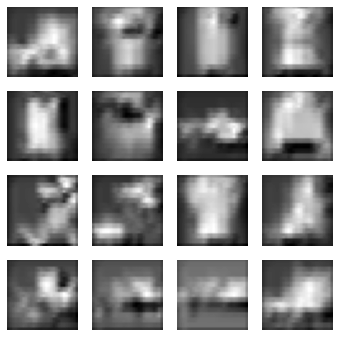

In [59]:
p =ae(xb)
show_images(p[:16].data.cpu(),imsize=1.5)

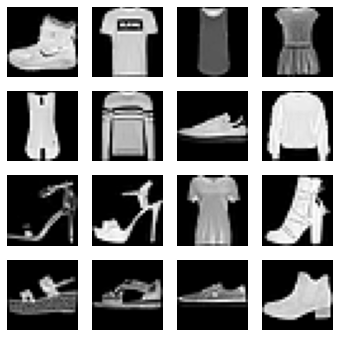

In [39]:
show_images(xb[:16].data.cpu(),imsize=1.5)